## CDMs - Análisis por riesgo

En esta notebook hacemos una primera revisión de los datos de entrenamiento

### Carga de librerías y setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

### Carga de datos crudos

In [3]:
data = pd.read_csv('./train_data/train_data.csv')

Definimos un campo que sea un ID de cada CMD dentro de un mismo evento

In [4]:
data = data.sort_values(["event_id", "time_to_tca"], ascending=[True, False])

In [5]:
data["cmd_id"] = data.groupby("event_id")["time_to_tca"].rank(ascending=False)

C:\Users\pablo\AppData\Local\Temp\ipykernel_32020\279891090.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["cmd_id"] = data.groupby("event_id")["time_to_tca"].rank(ascending=False)


In [6]:
avg_t_h_apo = data.groupby("mission_id")["t_h_apo"].mean().reset_index()

In [7]:
def get_LEO_type(x):
    if x < 550:
        return "LOW"
    elif x >= 550 and x <= 750:
        return "MEDIUM"
    else:
        return "HIGH"

In [8]:
avg_t_h_apo["type_of_mission"] = avg_t_h_apo["t_h_apo"].apply(get_LEO_type)

In [9]:
data = data.merge(avg_t_h_apo[["mission_id", "type_of_mission"]], on="mission_id")

### Análisis

Generamos un histograma de la variable riesgo

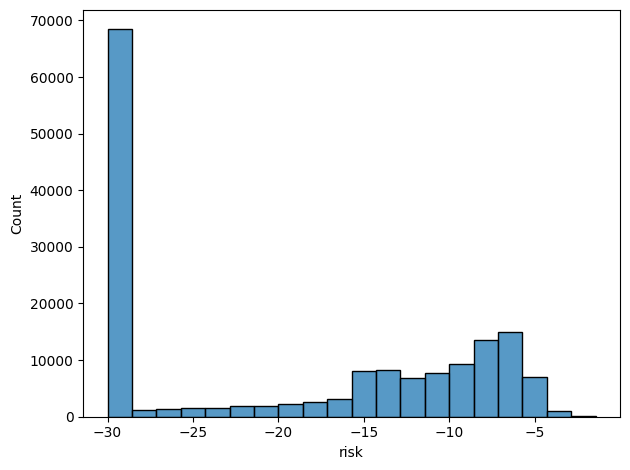

In [10]:
sns.histplot(data=data, x="risk", bins=20)
plt.tight_layout()
plt.show()


El valor del riesgo cambia a lo largo del CMD, revisamos los valores en el primer y último CMD en cada evento

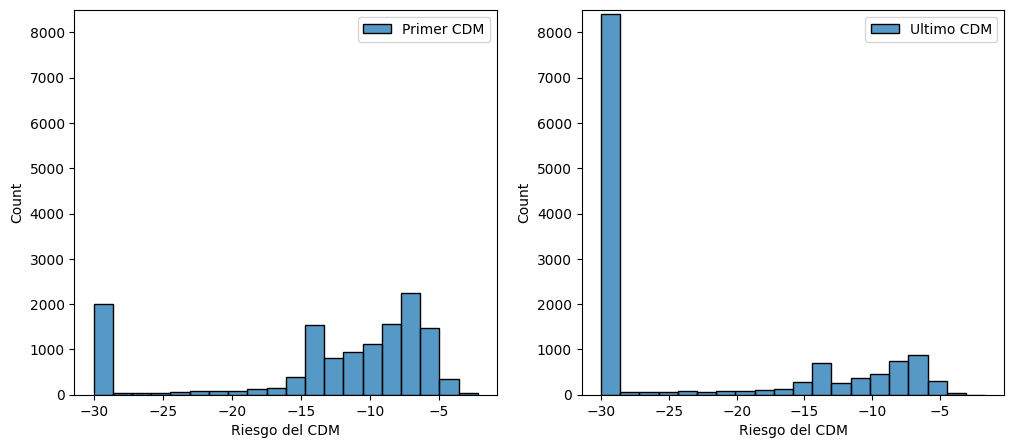

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(
    data=data.groupby('event_id').first()[["risk"]].rename(columns={"risk": "first_risk"}).reset_index(), 
    x="first_risk", 
    bins=20,
    label="Primer CDM",
    ax=axs[0])
sns.histplot(
    data=data.groupby('event_id').last()[["risk"]].rename(columns={"risk": "last_risk"}).reset_index(), 
    x="last_risk", 
    bins=20,
    label="Ultimo CDM",
    ax=axs[1])
axs[0].set_xlabel("Riesgo del CDM")
axs[1].set_xlabel("Riesgo del CDM")
axs[0].set_ylim(0, 8500)
axs[1].set_ylim(0, 8500)
axs[0].legend()
axs[1].legend()
plt.show()

Repetimos el análisis para cada tipo de misión

Tipo de misión: MEDIUM
Cantidad de eventos: 7627


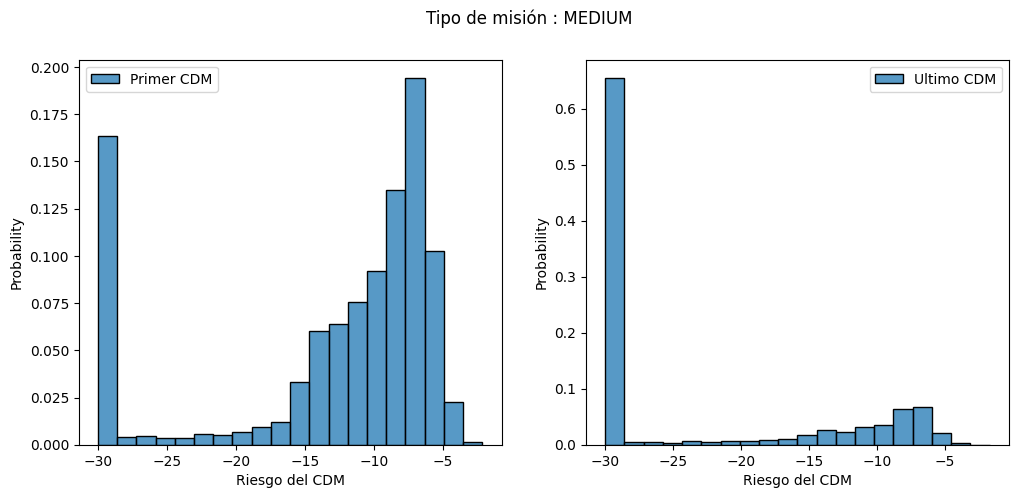

Tipo de misión: HIGH
Cantidad de eventos: 2483


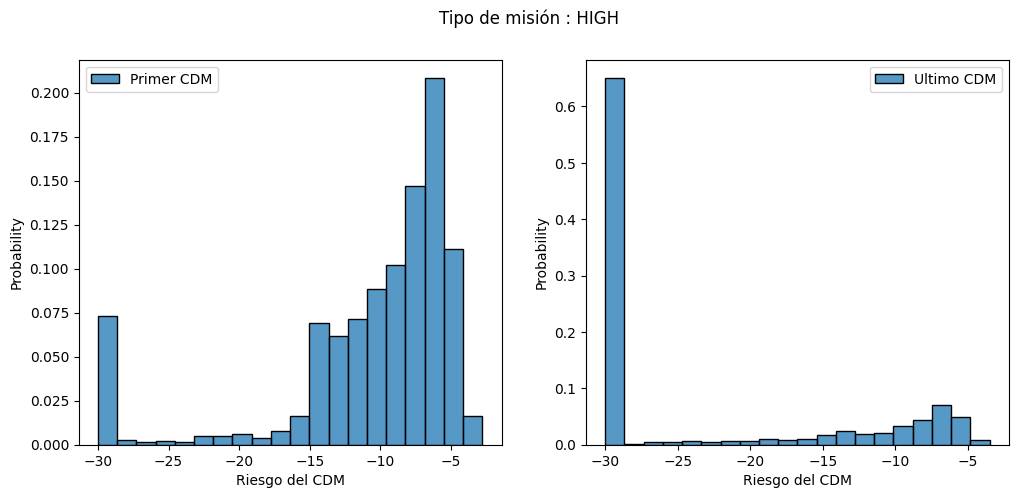

Tipo de misión: LOW
Cantidad de eventos: 3044


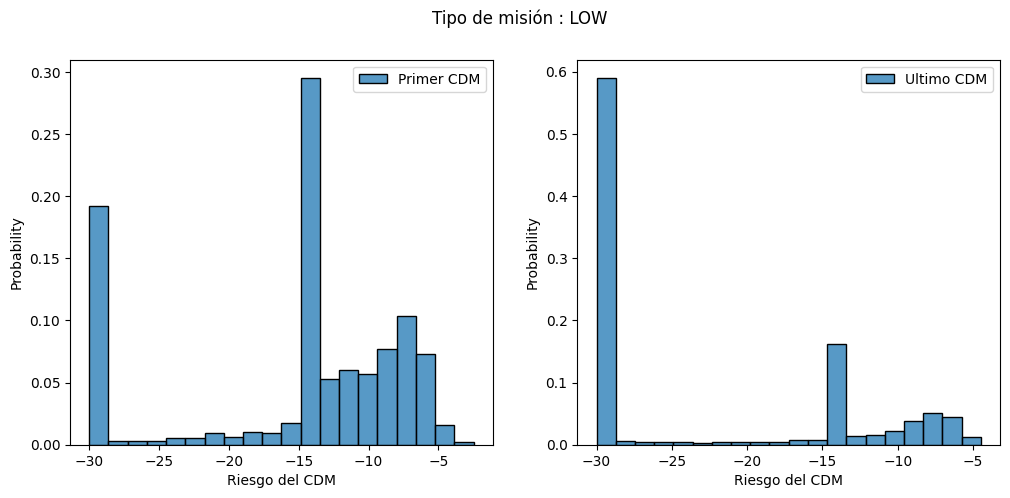

In [ ]:
for type_of_mission in data["type_of_mission"].unique():
    print(f"Tipo de misión: {type_of_mission}")
    print(f"Cantidad de eventos: {data[data['type_of_mission'] == type_of_mission]['event_id'].nunique()}")
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    df = data[data["type_of_mission"] == type_of_mission]
    
    sns.histplot(
        data=df.groupby('event_id').first()[["risk"]].rename(columns={"risk": "first_risk"}).reset_index(), 
        x="first_risk", 
        bins=20,
        label="Primer CDM",
        stat="probability",
        ax=axs[0])
    sns.histplot(
        data=df.groupby('event_id').last()[["risk"]].rename(columns={"risk": "last_risk"}).reset_index(), 
        x="last_risk", 
        bins=20,
        label="Ultimo CDM",
        stat="probability",
        ax=axs[1])
    axs[0].set_xlabel("Riesgo del CDM")
    axs[1].set_xlabel("Riesgo del CDM")
    axs[0].legend()
    axs[1].legend()
    plt.suptitle(f"Tipo de misión : {type_of_mission}")
    plt.show()

Se observan la distribución del risk del primer CDM y del último CDM por evento, segmentado por tipo de misión (LOW, MEDIUM, HIGH).

En los tres tipos de misión se observa un patrón robusto:

1. Primer CDM
   - Distribución amplia y continua
   - Mayor volumen en valores intermedios (-15 a -7)
   - Presencia significativa de eventos en -30 (caso de saturación de mínima probabilidad)

2. Último CDM
   - Fuerte concentración de probabilidad en -30
   - Desaparición significativa del volumen en valores intermedios
   - Reducción clara de la cola de mayor riesgo

Así, se concluye que el sistema tiende a resolver el riesgo hacia valores mínimos a medida que avanza el seguimiento.

**Diferencias por capa orbital**

1. LOW LEO (< 550 km)
   - Mayor proporción inicial de eventos ya en -30
   - El riesgo se resuelve rápidamente
   - Distribución final extremadamente concentrada en -30

   Así, en baja LEO el entorno dinámico (mayor arrastre atmosférico) puede acelerar la divergencia de trayectorias y facilitar la resolución temprana.

2. MEDIUM LEO (550 - 750 km)
   - Distribución inicial más balanceada
   - Volumen importante en rango intermedio
   - Fuerte migración hacia -30 en el último CDM
   
   La zona está más congestionada por lo que hay mayor persistencia inicial del riesgo, pero igualmente alta capacidad de resolución con observaciones adicionales.

3. HIGH LEO (> 750 km dentro de LEO)
   - Mayor perso inicial en rango intermedio
   - Persistencia ligeramente mayor del riesgo intermedio
   - Colapso final hacia -30 como en casos anteriores
   
   Al tener menor arrastre atmosférico las trayectorias son más estables, por lo que el riesgo tarda en disiparse pero el sistema termina descartando la mayoría de eventos

Evaluamos ahora, por tipo de misión LEO, cual es el porcentaje de eventos en los que el riesgo se incrementa, disminuye, o no se altera, al comparar el primer y último CDM

In [32]:
df = data.groupby(["type_of_mission", "event_id"]).agg({"risk": "first"}).rename(columns={"risk": "first_risk"}).reset_index().merge(data.groupby(["type_of_mission", "event_id"]).agg({"risk": "last"}).rename(columns={"risk": "last_risk"}).reset_index(), on=["type_of_mission", "event_id"])
df["risk_increased"] = (df["last_risk"] > df["first_risk"]).astype(int)
df["risk_decreased"] = (df["last_risk"] < df["first_risk"]).astype(int)
df["risk_unchanged"] = (df["last_risk"] == df["first_risk"]).astype(int)

In [34]:
df.groupby("type_of_mission")["risk_increased"].mean()

type_of_mission
HIGH      0.134917
LOW       0.188568
MEDIUM    0.130982
Name: risk_increased, dtype: float64

In [35]:
df.groupby("type_of_mission")["risk_unchanged"].mean()

type_of_mission
HIGH      0.064035
LOW       0.199080
MEDIUM    0.159434
Name: risk_unchanged, dtype: float64

In [36]:
df.groupby("type_of_mission")["risk_decreased"].mean()

type_of_mission
HIGH      0.801047
LOW       0.612352
MEDIUM    0.709584
Name: risk_decreased, dtype: float64

Luego de evaluar, para cada evento y tipo de misión (LOW, MEDIUM, HIGH), si el valor de risk:

- Aumenta (last_risk > first_risk)
- Disminuye (last_risk < first_risk)
- Permanece igual (last_risk == first_risk)

Los resultados obtenidos fueron los siguientes:

| Tipo de misión | ↓ Disminuye    | ↑ Aumenta      | = Igual        |
| -------------- | -------------- | -------------- | -------------- |
| **HIGH**       | 0.8010 (80.1%) | 0.1349 (13.5%) | 0.0640 (6.4%)  |
| **MEDIUM**     | 0.7096 (70.9%) | 0.1310 (13.1%) | 0.1594 (15.9%) |
| **LOW**        | 0.6124 (61.2%) | 0.1886 (18.9%) | 0.1991 (19.9%) |

Vemos que en todos los tipos de misión LEO la probabilidad de que el riesgo disminuya es significativamente dominante. El sistema tiende a reducir el riesgo a lo largo del proceso de seguimiento. Sin embargo, el comportamiento no es homogéneo:

1. HIGH LEO
   - 80% de los eventos reducen su riesgo
   - Solo 13.5% lo incrementan
   - Muy baja proporción de eventos estables
   
   El sistema es altamente filtrador en esta capa. La mayoría de los encuentros iniciales se descartan tras refinamiento orbital.

2. MEDIUM LEO
   - 71% disminuyen
   - 13% aumentan
   - 16% permanecen iguales
   
   En esta zona intermedia existe estabilidad dinámica

3. LOW LEO
   - Solo 61% disminuyen
   - 19% aumentan
   - 20% permanecen iguales
   
   Vemos que existe mayor proporción de incrementos del riesgo, de eventos estables y menor proporción de reducciones.

El sistema presenta un comportamiento conservador inicial, pero el grado y dirección de la corrección dependen del régimen dinámico orbital. 

**Conclusiones**

El análisis demuestra que:

- El sistema tiende a reducir el riesgo en la mayoría de los eventos.
- La intensidad de esta reducción varía con la altitud.
- LOW LEO muestra mayor probabilidad de incremento del riesgo.
- HIGH LEO muestra mayor probabilidad de reducción.
- La dinámica del riesgo es físico-operacional y dependiente del régimen orbital.

Este resultado refuerza la hipótesis de que el valor de risk observado en el dataset refleja no solo geometría instantánea, sino también dinámica orbital y comportamiento operativo del sistema de análisis de conjunciones.

Calculamos la correlación entre el riesgo en el primer y último CMD

In [37]:
pd.concat(
    [
        data.groupby('event_id').first()[["risk"]].rename(columns={"risk": "first_risk"}),
        data.groupby('event_id').last()[["risk"]].rename(columns={"risk": "last_risk"})
    ],
    axis=1
).corr()

,first_risk,last_risk
first_risk,1.000000,0.248972
last_risk,0.248972,1.000000


Segmentando por tipo de misión misión

In [43]:
pd.concat(
    [
        data.groupby(['type_of_mission', 'event_id']).first()[["risk"]].rename(columns={"risk": "first_risk"}),
        data.groupby(['type_of_mission', 'event_id']).last()[["risk"]].rename(columns={"risk": "last_risk"})
    ],
    axis=1
).reset_index().groupby("type_of_mission")[["first_risk", "last_risk"]].corr()

first_risk  last_risk
type_of_mission                                  
HIGH            first_risk    1.000000   0.227780
                last_risk     0.227780   1.000000
LOW             first_risk    1.000000   0.101005
                last_risk     0.101005   1.000000
MEDIUM          first_risk    1.000000   0.325396
                last_risk     0.325396   1.000000

Se calculó la correlación entre el risk del primer CDM (first_risk) y el del último CDM (last_risk) para cada evento

|                | first_risk | last_risk |
| -------------- | ---------- | --------- |
| **first_risk** | 1.000      | 0.249     |
| **last_risk**  | 0.249      | 1.000     |

La correlación global es 0.249, lo que indica:

- Existe relación positiva.
- La relación es débil.
- El riesgo inicial explica muy poco del riesgo final.
- El proceso de actualización del riesgo es dinámico y no determinista.

Por tanto, el valor inicial del riesgo no es un buen predictor lineal del valor final. Al analizar por tipo de misión se obtienen los siguientes resultados

| Tipo de misión | Correlación (first vs last) |
| -------------- | --------------------------- |
| **HIGH**       | 0.228                       |
| **MEDIUM**     | 0.325                       |
| **LOW**        | 0.101                       |

1. HIGH LEO
   
   - Correlación débil (0.228)
   - El riesgo sufre correcciones importantes
   - El sistema actúa de manera fuertemente refinadora
   
   En alta LEO, el riesgo inicial tiende a ser corregido significativamente a lo largo del seguimiento.

2. MEDIUM LEO
   
   - Correlación más alta (0.325)
   - El riesgo inicial es relativamente más persistente
   - Mayor estabilidad estructural
   
   En LEO media, el riesgo inicial conserva más información predictiva respecto del riesgo final.

3. LOW LEO
   
   - Correlación muy baja (0.101).
   - El riesgo inicial casi no contiene información sobre el riesgo final
   - Mayor volatilidad en la actualización
   
   En baja LEO, el proceso es más reactivo y sensible a nueva información, probablemente influenciado por mayor drag atmosférico y dinámica más variable.

Consideramos ahora todos los eventos que tienen una medida de TCA menor a 1 día (únicos eventos presentes en el conjunto de testeo)

In [44]:
events_with_latest_tca_lt_1 = (data.groupby("event_id")["time_to_tca"].min()[data.groupby("event_id")["time_to_tca"].min() < 1]).index.tolist()
data_filtered = data[data["event_id"].isin(events_with_latest_tca_lt_1)]

Y todos los eventos que tienen un CDM con TCA mayor a 2 días

In [45]:
events_with_first_tca_gt_2 =(data_filtered.groupby("event_id")["time_to_tca"].max()[data_filtered.groupby("event_id")["time_to_tca"].max() > 2]).index.tolist()
data_filtered = data_filtered[data_filtered["event_id"].isin(events_with_first_tca_gt_2)]

Para esos eventos, calculamos la correlación entre el riesgo en la última medición previa a 2 días del TCA y el último riesgo medido

In [46]:
pd.concat(
    [
        data_filtered[data_filtered["time_to_tca"] >= 2].groupby("event_id").last()[["risk"]].rename(columns={"risk": "risk_gt_2"}),
        data_filtered.groupby("event_id").last()[["risk"]].rename(columns={"risk": "risk_final"})
    ],
    axis=1
).corr()

,risk_gt_2,risk_final
risk_gt_2,1.000000,0.478809
risk_final,0.478809,1.000000


In [52]:
pd.concat(
    [
        data_filtered[data_filtered["time_to_tca"] >= 2].groupby(["type_of_mission", "event_id"]).last()[["risk"]].rename(columns={"risk": "risk_gt_2"}),
        data_filtered.groupby(["type_of_mission", "event_id"]).last()[["risk"]].rename(columns={"risk": "risk_final"})
    ],
    axis=1
).reset_index().groupby("type_of_mission")[["risk_gt_2", "risk_final"]].corr()

risk_gt_2  risk_final
type_of_mission                                  
HIGH            risk_gt_2    1.000000    0.562906
                risk_final   0.562906    1.000000
LOW             risk_gt_2    1.000000    0.250831
                risk_final   0.250831    1.000000
MEDIUM          risk_gt_2    1.000000    0.531427
                risk_final   0.531427    1.000000

|                | risk_gt_2 | risk_final |
| -------------- | --------- | ---------- |
| **risk_gt_2**  | 1.000     | 0.479      |
| **risk_final** | 0.479     | 1.000      |

Esto indica:

- Relación positiva moderada
- Mucho más alta que la correlación entre primer y último CDM
- El riesgo medido al menos 2 días antes del TCA sí contiene información relevante sobre el riesgo final.

Esto confirma que el problema es estructuralmente aprendible.

| Tipo de misión | Correlación (≥2 días vs final) |
| -------------- | ------------------------------ |
| **HIGH**       | 0.563                          |
| **MEDIUM**     | 0.531                          |
| **LOW**        | 0.251                          |

1. HIGH LEO (0.563)
   
   - Relación moderadamente fuerte
   - Mayor estabilidad dinámica
   - Menor volatilidad estructural
   
   En HIGH LEO, el riesgo temprano ya captura buena parte de la estructura final

2. MEDIUM LEO (0.531)
   
   - Muy similar a HIGH
   - El sistema mantiene persistencia del riesgo
   - Correcciones posteriores son más refinamientos que cambios estructurales

3. LOW LEO (0.251)
   
   - Correlación baja
   - El riesgo 2 días antes del TCA tiene poca capacidad predictiva
   - Mayor volatilidad entre mayor a 2 días y el TCA

En LOW LEO, la evolución del riesgo es mucho más inestable y sensible a nueva información. Esto es consistente con:

- Mayor drag atmosférico
- Mayor variabilidad orbital
- Mayor sensibilidad a perturbaciones


Gráficamente

In [53]:
df = pd.concat(
        [
            data_filtered[data_filtered["time_to_tca"] >= 2].groupby("event_id").last()[["risk"]].rename(columns={"risk": "risk_gt_2"}),
            data_filtered.groupby("event_id").last()[["risk"]].rename(columns={"risk": "risk_final"})
        ],
        axis=1
    )

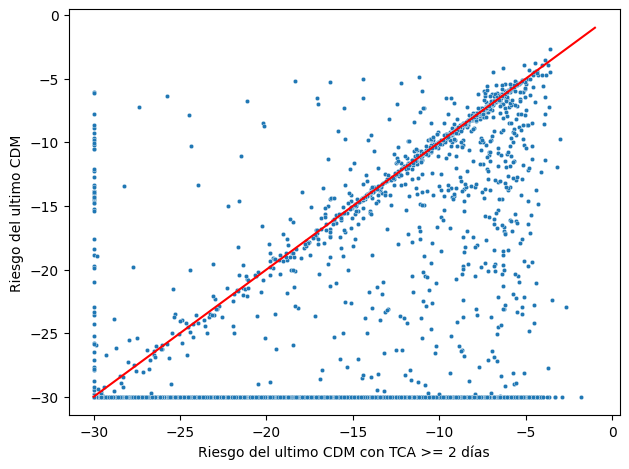

In [54]:
sns.scatterplot(
    data=df,
    x="risk_gt_2",
    y="risk_final",
    s=10
)
plt.xlabel("Riesgo del ultimo CDM con TCA >= 2 días")
plt.ylabel("Riesgo del ultimo CDM")
plt.plot([-30, -1], [-30, -1], color="red", linestyle="-")
plt.tight_layout()
plt.show()

Tipo de misión: HIGH


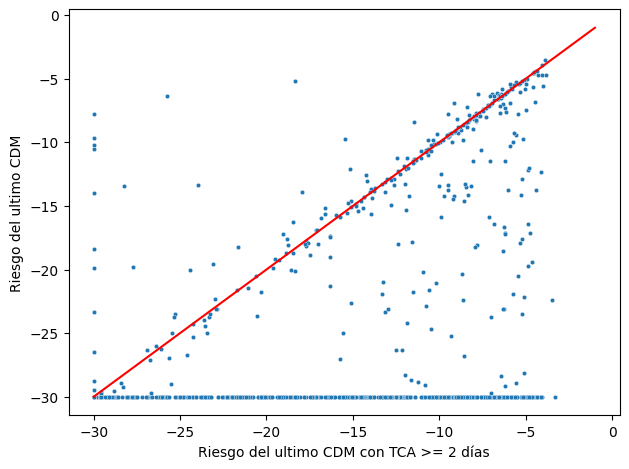


Tipo de misión: MEDIUM


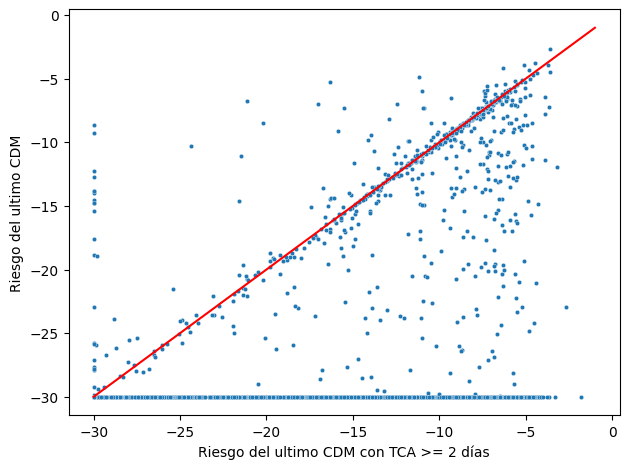


Tipo de misión: LOW


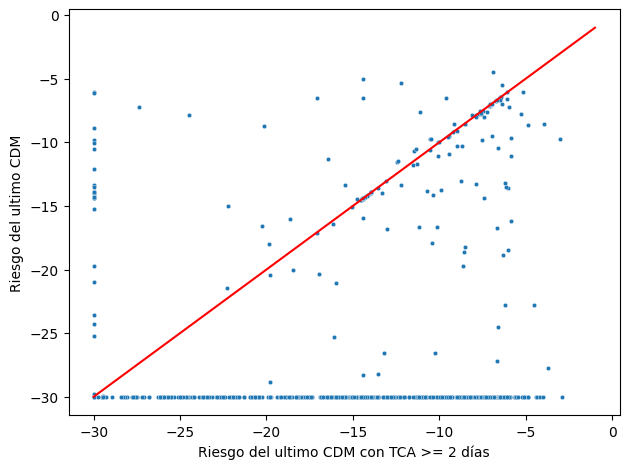

In [61]:
for type_of_mission in data_filtered["type_of_mission"].unique():
    print(f"Tipo de misión: {type_of_mission}")
    df = pd.concat(
        [
            data_filtered[(data_filtered["time_to_tca"] >= 2) & (data_filtered["type_of_mission"]==type_of_mission)].groupby("event_id").last()[["risk"]].rename(columns={"risk": "risk_gt_2"}),
            data_filtered[data_filtered["type_of_mission"]==type_of_mission].groupby("event_id").last()[["risk"]].rename(columns={"risk": "risk_final"})
        ],
        axis=1
    )
    sns.scatterplot(
        data=df,
        x="risk_gt_2",
        y="risk_final",
        s=10
    )
    plt.xlabel("Riesgo del ultimo CDM con TCA >= 2 días")
    plt.ylabel("Riesgo del ultimo CDM")
    plt.plot([-30, -1], [-30, -1], color="red", linestyle="-")
    plt.tight_layout()
    plt.show()
    print()